In [1]:
# Standard data manipulation/visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Custom text cleaning tool
import text_cleaner as cln

# Word clound library tools
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# Sentiment analysis libraries
from textblob import TextBlob
import flair

# Interactive dashboard library
import streamlit

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uddin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uddin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
input_file = "../data/comments.csv"
raw_comments = pd.read_csv(input_file, lineterminator='\n')

In [ ]:
data = raw_comments.drop(['videoId', 'commentId', 'author'], axis=1)

# Preprocessing

In [ ]:
cleaner = cln.TextCleaner()
cleaned_comments = cleaner.clean(data['text'].astype(str))

In [ ]:
cleaned_data = data.copy()
cleaned_data['cleaned_comments'] = cleaned_comments

In [ ]:
cleaned_data.to_json('../data/cleaned_comments.csv')

# Sentiment Analysis

In [ ]:
sentiment_analysis = cleaned_data.copy()

## TextBlob pre-trained model

In [82]:
textblob_results = {"positive":0,"neutral":0,"negative":0}
sentiment_polarity = []
sentiment_subj = []
for x in cleaned_data['cleaned_comments']: 
    res = TextBlob(x).sentiment
    sentiment_polarity.append(res[0])
    sentiment_subj.append(res[1])
    if res[0] == 0.0: 
        textblob_results["neutral"] +=1
    elif res[0] > 0.0:
        textblob_results["positive"] +=1
    else:
        textblob_results["negative"] +=1
print(textblob_results)

{'positive': 53478, 'neutral': 78999, 'negative': 39304}


In [ ]:
labels = textblob_results.keys()
percentages = textblob_results.values()
explode = (0.1, 0, 0)

fig, ax = plt.subplots()
ax.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

plt.show()

In [ ]:
sentiment_analysis['textblob_polarity'] = sentiment_polarity
sentiment_analysis['textblob_subjectivity'] = sentiment_subj

## Flair pre-built model

In [ ]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [ ]:
flair_results = {"positive":0, "negative":0}
sentiment_val = []
sentiment_score = []
for x in cleaned_data['cleaned_comments']: 
    sentiment = flair.data.Sentence(x)
    flair_sentiment.predict(sentiment)
    res = sentiment.labels
    res = str(res[0]).replace('(', '').replace(')', '').split(' ')
    sentiment_val.append(res[0])
    sentiment_score.append(res[1])
    if res[0] == "POSITIVE":
        flair_results["positive"] +=1
    else:
        flair_results["negative"] +=1
print(flair_results)

In [ ]:
labels = flair_results.keys()
percentages = flair_results.values()
explode = (0.1, 0)

fig, ax = plt.subplots()
ax.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

plt.show()

In [ ]:
sentiment_analysis['flair_sentiment'] = sentiment_val
sentiment_analysis['flair_score'] = sentiment_score

In [ ]:
sentiment_analysis.to_json('../data/sentiment_analysis.csv')

In [ ]:
model_results = pd.DataFrame()
model_results = model_results.append(pd.DataFrame(data=[textblob_results.values()], columns=['positive', 'neutral', 'negative'], index=['textblob']))
model_results = model_results.append(pd.DataFrame(data=[flair_results.values()], columns=['positive', 'negative'], index=['flair']))
model_results.to_csv('../data/model_results.csv')

# Data Visualization

In [2]:
df = pd.read_json("../data/sentiment_analysis.csv")

df.head()

,text,likeCount,publishedAt,cleaned_comments,textblob_polarity,textblob_subjectivity,flair_sentiment,flair_score,comment_length
0,This game are mix with the 80s and the future....,0,2020-05-25T10:59:01Z,"[game, mix, future, uwu, thats, neat]",-0.200000,0.2625,POSITIVE,0.9821,65
1,"29:02 ""Remember, these guys are really *shit* """,0,2020-05-25T10:56:37Z,"[remember, guy, really, shit]",-0.200000,0.8000,NEGATIVE,0.9993,47
2,I would replay this game 100x 💯‼,1,2020-05-25T10:19:23Z,"[would, replay, game, x]",-0.400000,0.4000,NEGATIVE,0.7817,32
3,So you could complete the game without killing...,1,2020-05-25T10:18:57Z,"[could, complete, game, without, killing, anyone]",-0.150000,0.4000,NEGATIVE,0.9934,55
4,"After listening to this video, I'm wondering i...",0,2020-05-25T09:54:34Z,"[listening, video, im, wondering, mod, music, ...",0.033333,0.6000,NEGATIVE,0.9955,209


In [ ]:
mask = np.array(Image.open('reeves.png'))

In [ ]:
words = ''
for x in df['cleaned_comments']:
    words += "".join(str(x).strip("[]").replace("'", "").replace(",", ""))

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=10000, random_state=42, mask=mask).generate(words)

In [ ]:
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.show()

### Optimizing the model results data frame

In [45]:
# TODO: fix previous creation of data frame

In [27]:
model_results = pd.read_csv('../data/model_results.csv')

In [4]:
# model_results = model_results.rename(columns={"Unnamed: 0":""})
# model_results = model_results.T
# model_results.columns = model_results.iloc[0]
# model_results = model_results.drop(model_results.index[0])
# model_results

In [28]:
model_results = model_results.set_index('Sentiment')
model_results

,textblob,flair
Sentiment,,
Positive,53478.0,70402.0
Neutral,78999.0,NaN
Negative,39304.0,101379.0


In [41]:
# model_results.to_csv('../data/model_results.csv')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016659438640>,
      dtype=object)

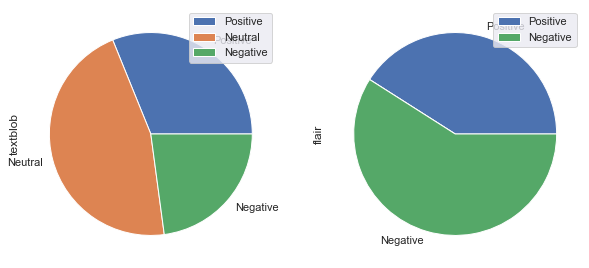

In [44]:
model_results.plot.pie(subplots=True, figsize=(10, 10))

## Likes

In [37]:
top_10_liked = df.sort_values(by=['likeCount'], ascending=False).head(10)

In [39]:
print('*Top 10 liked comments*\n')
for c, d, l, t, f in zip(top_10_liked['text'], top_10_liked['publishedAt'], top_10_liked['likeCount'], top_10_liked['textblob_polarity'], top_10_liked['flair_sentiment']):
    print('Date: ' + (d))
    print('Like Count: ' + str(l))
    print(c, end='\n\n')
    print('text_blob: ' + str(t))
    print('flair: ' + str(f), end='\n-------------------------------------------------------------------------------\n')

*Top 10 liked comments*

Date: 2019-06-12T07:39:08Z
Like Count: 36240
*May contain content inappropriate for children*

Well the ones who saw the teaser back then aren't kids anymore

text_blob: 0.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Date: 2018-08-28T16:31:21Z
Like Count: 30947
This game will kill all interaction I have with humans for weeks...thankyou

text_blob: -0.2
flair: NEGATIVE
-------------------------------------------------------------------------------
Date: 2019-06-19T14:43:30Z
Like Count: 20818
“A futuristic game that takes place in the year 2077”

*Actually comes out in 2077*

text_blob: -0.2
flair: POSITIVE
-------------------------------------------------------------------------------
Date: 2018-08-27T20:40:17Z
Like Count: 17737
I almost wish I didn't know about this, because now the wait is going to be so painful...

text_blob: -0.7000000000000001
flair: NEGATIVE
----------------------------------------------

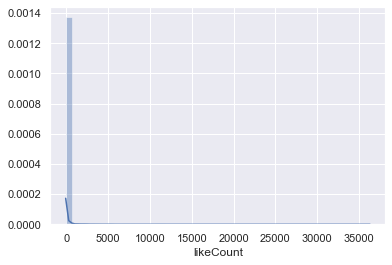

In [181]:
sns.distplot(df['likeCount'])

## TextBlob

In [185]:
top_10_textblob_pol_pos = df.sort_values(by=['textblob_polarity'], ascending=False).head(10)

In [191]:
print('*Top 10 TextBlob positive polarity sentiment*\n')
for c, l, t, f in zip(top_10_textblob_pol_pos['text'], top_10_textblob_pol_pos['likeCount'], top_10_textblob_pol_pos['textblob_polarity'], top_10_textblob_pol_pos['flair_sentiment']):
    print('Like Count: ' + str(l))
    print(c, end='\n\n')
    print('textblob_polarity: ' + str(t))
    print('flair: ' + str(f), end='\n-------------------------------------------------------------------------------\n')

*Top 10 TextBlob positive polarity sentiment*

Like Count: 1
Best part: NO BATTLE ROYALE...

textblob_polarity: 1.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 0
Anyone else got a boner watching this? This is going to be freaking awesome!

textblob_polarity: 1.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 1
*NO YOUR BREATHTAKING*

textblob_polarity: 1.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 0
Superb. 👍👍👍👍👍😁🍗👏💥

textblob_polarity: 1.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 0
2020 still the best thing on internet......ermygurd i luv cdpk

textblob_polarity: 1.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 0
This is sooo awesome!!! Well done CDRP! Now shut up and t

In [188]:
top_10_textblob_pol_neg = df.sort_values(by=['textblob_polarity']).head(10)

In [192]:
print('*Top 10 TextBlob positive polarity sentiment*\n')
for c, l, t, f in zip(top_10_textblob_pol_neg['text'], top_10_textblob_pol_neg['likeCount'], top_10_textblob_pol_neg['textblob_polarity'], top_10_textblob_pol_neg['flair_sentiment']):
    print('Like Count: ' + str(l))
    print(c, end='\n\n')
    print('textblob_polarity: ' + str(t))
    print('flair: ' + str(f), end='\n-------------------------------------------------------------------------------\n')

*Top 10 TextBlob positive polarity sentiment*

Like Count: 0
I wish I could like this. It's boring, unimaginative, and feels unfinished. Vocals are being squeezed by the guitars, drowning them out.

textblob_polarity: -1.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 0
Imagine how insane this would look Iif the RTX version was shown.

textblob_polarity: -1.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 0
Looks fecking boring

textblob_polarity: -1.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 0
The level of details is insane!!

textblob_polarity: -1.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 0
After witcher 3 that looks boring... =/

textblob_polarity: -1.0
flair: NEGATIVE
-------------------------------------------------------------

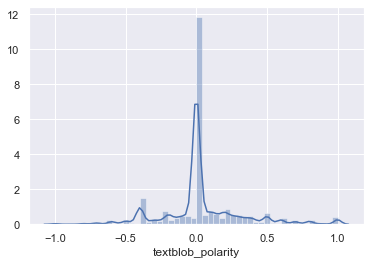

In [33]:
sns.distplot(df['textblob_polarity'])

In [189]:
top_10_textblob_subj_pos = df.sort_values(by=['textblob_subjectivity'], ascending=False).head(10)

In [193]:
print('*Top 10 TextBlob positive polarity sentiment*\n')
for c, l, t, f in zip(top_10_textblob_subj_pos['text'], top_10_textblob_subj_pos['likeCount'], top_10_textblob_subj_pos['textblob_subjectivity'], top_10_textblob_subj_pos['flair_sentiment']):
    print('Like Count: ' + str(l))
    print(c, end='\n\n')
    print('textblob_subjectivity: ' + str(t))
    print('flair: ' + str(f), end='\n-------------------------------------------------------------------------------\n')

*Top 10 TextBlob positive polarity sentiment*

Like Count: 0
How to buy it in Ukraine? On your pre-order page it is impossible.

textblob_subjectivity: 1.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 0
FINALLY A RELEASE DATE

textblob_subjectivity: 1.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 0
Now that's what you call Breathtaking!

textblob_subjectivity: 1.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 0
create a class tits are censored but then 4:48 wtf

textblob_subjectivity: 1.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 0
WOW Keanu Reeves!

textblob_subjectivity: 1.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 0
i showed this to my dad






now he's breathtaking

In [194]:
top_10_textblob_subj_neg = df.sort_values(by=['textblob_subjectivity']).head(10)

In [195]:
print('*Top 10 TextBlob positive polarity sentiment*\n')
for c, l, t, f in zip(top_10_textblob_subj_neg['text'], top_10_textblob_subj_neg['likeCount'], top_10_textblob_subj_neg['textblob_subjectivity'], top_10_textblob_subj_neg['flair_sentiment']):
    print('Like Count: ' + str(l))
    print(c, end='\n\n')
    print('textblob_subjectivity: ' + str(t))
    print('flair: ' + str(f), end='\n-------------------------------------------------------------------------------\n')

*Top 10 TextBlob positive polarity sentiment*

Like Count: 0
Опа , сиськи . Придется покупать .

textblob_subjectivity: 0.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 2
Its like ghost in the shell and apple seed

textblob_subjectivity: 0.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 2
6.7K dislikes from [EA]

textblob_subjectivity: 0.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 1
Квас - не кола, пей Николу )

textblob_subjectivity: 0.0
flair: POSITIVE
-------------------------------------------------------------------------------
Like Count: 1
A subsribe how subsribe

textblob_subjectivity: 0.0
flair: NEGATIVE
-------------------------------------------------------------------------------
Like Count: 5
take my money

textblob_subjectivity: 0.0
flair: NEGATIVE
------------------------------------

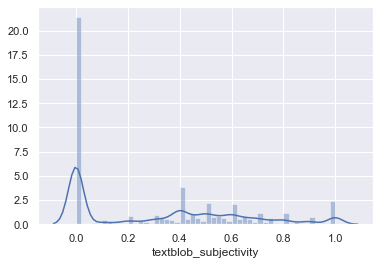

In [165]:
sns.distplot(df['textblob_subjectivity'])

## Flair

In [36]:
top_10_flair_pos = df.sort_values(by=['flair_sentiment', 'flair_score'], ascending=False).head(10)
top_10_flair_pos

,text,likeCount,publishedAt,cleaned_comments,textblob_polarity,textblob_subjectivity,flair_sentiment,flair_score
17437,"I feel stuff like Dan Terminus, Petrurbator, C...",75,2019-12-13T03:21:39Z,"[feel, stuff, like, dan, terminus, petrurbator...",0.666667,0.766667,POSITIVE,1.0000
35693,am i the only one who thinks that Samurai's ha...,0,2019-07-09T16:22:10Z,"[one, think, samurai, hairstyle, weirdly, supe...",0.231250,0.587500,POSITIVE,1.0000
48609,"The detail they put in what they do, the thing...",3,2019-06-11T21:42:26Z,"[detail, put, thing, surprise, u, sound, music...",0.307143,0.450000,POSITIVE,1.0000
55241,"The detail they put in what they do, the thing...",0,2019-06-10T14:12:43Z,"[detail, put, thing, surprise, u, sound, music...",0.307143,0.450000,POSITIVE,1.0000
58822,At first God created Keanu Reeves and it was a...,41,2019-06-10T07:03:55Z,"[first, god, created, keanu, reef, wa, awesome...",0.750000,0.777778,POSITIVE,1.0000
95150,This game is first person because you are supp...,0,2018-08-31T16:05:07Z,"[game, first, person, supposed, playing, witch...",0.237500,0.458333,POSITIVE,1.0000
126248,You are not only paying respects to the origin...,0,2018-08-27T17:52:42Z,"[paying, respect, original, nailed, live, see,...",0.258766,0.604762,POSITIVE,1.0000
156852,Waiting for someone who wouldn't mess with the...,0,2014-07-05T16:39:18Z,"[waiting, someone, wouldnt, mess, base, materi...",0.006250,0.393750,POSITIVE,1.0000
1940,"Folks, I have to say that original version of ...",1,2020-05-10T17:28:31Z,"[folk, say, original, version, song, wa, best,...",0.687500,0.525000,POSITIVE,0.9999
4478,I thought it was a custom cyberpunk PC fully r...,0,2020-04-12T20:41:45Z,"[thought, wa, custom, cyberpunk, pc, fully, re...",0.266667,0.633333,POSITIVE,0.9999


In [37]:
top_10_flair_neg = df.sort_values(by=['flair_sentiment', 'flair_score']).head(10)
top_10_flair_neg

,text,likeCount,publishedAt,cleaned_comments,textblob_polarity,textblob_subjectivity,flair_sentiment,flair_score
42211,I better have an option to wear a cop outfit l...,0,2019-06-23T05:27:30Z,"[better, option, wear, cop, outfit, like, ingame]",0.500000,0.500000,NEGATIVE,0.5000
128874,V-TECHH,0,2018-06-22T07:15:48Z,[vtechh],0.000000,0.000000,NEGATIVE,0.5000
14245,*HOT DÆMN!*,0,2019-12-19T17:14:12Z,"[hot, dmn]",0.250000,0.850000,NEGATIVE,0.5001
63415,ja quero jogarrr,0,2019-06-10T00:45:35Z,"[ja, quero, jogarrr]",0.000000,0.000000,NEGATIVE,0.5001
101151,Aliens made this game,0,2018-08-29T23:12:15Z,"[alien, made, game]",-0.325000,0.575000,NEGATIVE,0.5001
141925,Shadowrun meets GTA.........\nFinally!,0,2018-06-11T02:50:25Z,"[shadowrun, meet, gtafinally]",0.000000,0.000000,NEGATIVE,0.5001
168856,Hidden message tells to wait for february 5th ...,0,2013-01-11T12:21:44Z,"[hidden, message, tell, wait, february, th, th...",-0.188889,0.411111,NEGATIVE,0.5001
4599,41:00 aimbot be like,0,2020-04-11T06:32:17Z,"[aimbot, like]",0.000000,0.000000,NEGATIVE,0.5002
29737,13:33 😂 wtf is that supposed to be Keanu Reeve...,0,2019-08-30T21:11:58Z,"[wtf, supposed, keanu, reevesdisappointing]",-0.500000,1.000000,NEGATIVE,0.5002
109563,Why not give the players both a 1st and 3rd pl...,0,2018-08-28T17:39:38Z,"[give, player, st, rd, player, option]",0.000000,0.000000,NEGATIVE,0.5002


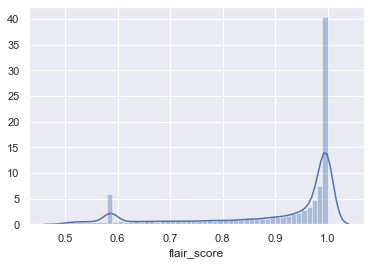

In [63]:
sns.distplot(df['flair_score'])

## TextBlob vs Flair

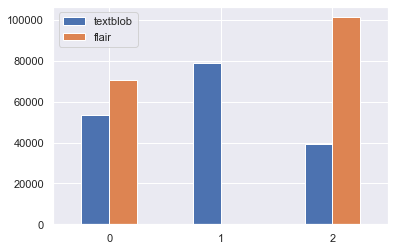

In [15]:
plot = model_results.plot.bar(rot=0)
fig = plot.get_figure()
plot

In [16]:
fig.savefig('../images/textblob-vs-flair')

## Comment Lengths

In [6]:
comment_length = []
for x in df['text']:
    comment_length.append(len(str(x)))

df['comment_length'] = comment_length

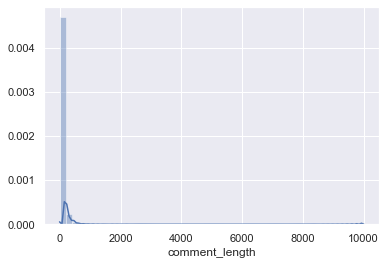

In [7]:
sns.distplot(df['comment_length'])

In [8]:
sort_by_comment_length = df.sort_values(by=['comment_length'], ascending=False).head(10)

In [9]:
sort_by_comment_length

,text,likeCount,publishedAt,cleaned_comments,textblob_polarity,textblob_subjectivity,flair_sentiment,flair_score,comment_length
92375,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,0,2018-09-02T10:01:02Z,[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,0.000000,0.000000,NEGATIVE,0.9777,10000
141771,Watch till the end!!!\nAAAAAAAAaaaaaaaaaa!!!!...,0,2018-06-11T03:16:23Z,"[watch, till, endaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...",0.000000,0.000000,NEGATIVE,0.9992,10000
117868,omg omg omg omg omg omg omg omg omg omg omg om...,49,2018-08-27T21:49:44Z,"[omg, omg, omg, omg, omg, omg, omg, omg, omg, ...",0.000000,0.000000,NEGATIVE,0.6052,9999
32475,Just here to dislike bomb. If you haven't hear...,1,2019-08-28T02:37:09Z,"[dislike, bomb, havent, heard, cdpr, sjw, dev,...",-0.333333,0.400000,NEGATIVE,0.9991,9372
32477,Just here to dislike bomb. If you haven't hear...,1,2019-08-28T02:36:57Z,"[dislike, bomb, havent, heard, cdpr, sjw, dev,...",-0.333333,0.400000,NEGATIVE,0.9991,9364
34758,This ideas for you CD Project Red:\n\nFirst i ...,0,2019-07-28T14:17:46Z,"[idea, cd, project, redfirst, give, another, c...",0.124722,0.523319,POSITIVE,0.7933,7991
5721,Hi Folks working on Cyberpunk 2077. Yes i've t...,0,2020-04-06T00:33:42Z,"[hi, folk, working, cyberpunk, yes, ive, tried...",0.066009,0.460056,NEGATIVE,0.9986,6843
87211,Do not blindly enjoy ANY story-line of a dysto...,0,2018-10-06T00:50:45Z,"[blindly, enjoy, storyline, dystopian, type, f...",0.109131,0.472398,NEGATIVE,0.9816,6320
32474,Just here to dislike bomb. If you haven't hear...,3,2019-08-28T02:37:15Z,"[dislike, bomb, havent, heard, cdpr, sjw, dev,...",-0.333333,0.400000,NEGATIVE,0.9991,6248
51056,"ourforgiveness.c*o*m \n""End Times""\nFriends, h...",0,2019-06-11T02:08:44Z,"[ourforgivenesscom, end, timesfriends, harken,...",0.118127,0.490454,NEGATIVE,0.9255,5328


In [17]:
# df.to_json('../data/sentiment_analysis.csv')

In [34]:
df.sort_values(by=['publishedAt']).head(10)

,text,likeCount,publishedAt,cleaned_comments,textblob_polarity,textblob_subjectivity,flair_sentiment,flair_score,comment_length
171780,yesyesyesyesyesyesyesyes,14,2012-10-19T08:18:18Z,[yesyesyesyesyesyesyesyes],0.000000,0.00,POSITIVE,0.9752,24
171779,I need MOAR music.,0,2012-10-19T08:35:20Z,"[need, moar, music]",0.000000,0.00,POSITIVE,0.9612,18
171778,oh yes! cant wait for more.,0,2012-10-19T08:37:11Z,"[oh, yes, cant, wait]",0.000000,0.00,NEGATIVE,0.9791,27
171777,wow!!! music is awesome!,4,2012-10-19T08:51:03Z,"[wow, music, awesome]",0.550000,1.00,POSITIVE,0.9961,24
171776,sends chills down my spine,0,2012-10-19T08:53:31Z,"[sends, chill, spine]",0.000000,0.00,POSITIVE,0.9662,26
171775,:O Which of the RPG-Gods answered my prayer?!?!,2,2012-10-19T09:12:41Z,"[rpggods, answered, prayer]",0.000000,0.00,POSITIVE,0.9154,47
171774,COOL MUSIC!VERY COOL!!!,0,2012-10-19T09:17:11Z,"[cool, musicvery, cool]",0.350000,0.65,POSITIVE,0.9965,23
171773,QUICK CHECK FRAME 47,0,2012-10-19T10:02:53Z,"[quick, check, frame]",0.333333,0.50,NEGATIVE,0.7917,20
171772,CDProjketRED did! :D,0,2012-10-19T10:03:54Z,[cdprojketred],0.000000,0.00,NEGATIVE,0.6994,20
171771,So stoked for this! :D,0,2012-10-19T10:04:57Z,[stoked],0.000000,0.00,POSITIVE,0.9988,22


In [31]:
model_results

,textblob,flair
Sentiment,,
Positive,53478.0,70402.0
Neutral,78999.0,NaN
Negative,39304.0,101379.0


In [7]:
df.to_csv('../data/csv_results.csv', index=False)

In [8]:
csv_results = pd.read_csv('../data/csv_results.csv')

In [9]:
csv_results

,text,likeCount,publishedAt,cleaned_comments,textblob_polarity,textblob_subjectivity,flair_sentiment,flair_score,comment_length
0,This game are mix with the 80s and the future....,0,2020-05-25T10:59:01Z,"['game', 'mix', 'future', 'uwu', 'thats', 'neat']",-0.200000,0.2625,POSITIVE,0.9821,65
1,"29:02 ""Remember, these guys are really *shit* """,0,2020-05-25T10:56:37Z,"['remember', 'guy', 'really', 'shit']",-0.200000,0.8000,NEGATIVE,0.9993,47
2,I would replay this game 100x 💯‼,1,2020-05-25T10:19:23Z,"['would', 'replay', 'game', 'x']",-0.400000,0.4000,NEGATIVE,0.7817,32
3,So you could complete the game without killing...,1,2020-05-25T10:18:57Z,"['could', 'complete', 'game', 'without', 'kill...",-0.150000,0.4000,NEGATIVE,0.9934,55
4,"After listening to this video, I'm wondering i...",0,2020-05-25T09:54:34Z,"['listening', 'video', 'im', 'wondering', 'mod...",0.033333,0.6000,NEGATIVE,0.9955,209
...,...,...,...,...,...,...,...,...,...
171776,sends chills down my spine,0,2012-10-19T08:53:31Z,"['sends', 'chill', 'spine']",0.000000,0.0000,POSITIVE,0.9662,26
171777,wow!!! music is awesome!,4,2012-10-19T08:51:03Z,"['wow', 'music', 'awesome']",0.550000,1.0000,POSITIVE,0.9961,24
171778,oh yes! cant wait for more.,0,2012-10-19T08:37:11Z,"['oh', 'yes', 'cant', 'wait']",0.000000,0.0000,NEGATIVE,0.9791,27
171779,I need MOAR music.,0,2012-10-19T08:35:20Z,"['need', 'moar', 'music']",0.000000,0.0000,POSITIVE,0.9612,18


In [3]:
import csv_to_sqlite
import sqlite3

# all the usual options are supported
# options = csv_to_sqlite.CsvOptions(typing_style="full", encoding="utf-8") 
# csv_to_sqlite.write_csv(['../data/csv_results.csv'], "sentiment_analysis_db.sqlite", options)

In [4]:
con = sqlite3.connect("sentiment_analysis_db.sqlite")
table_2012 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt < 2013", con)
table_2013 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt > 2013 AND publishedAt < 2014", con)
table_2014 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt > 2014 AND publishedAt < 2015", con)
table_2015 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt > 2015 AND publishedAt < 2016", con)
table_2016 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt > 2016 AND publishedAt < 2017", con)
table_2017 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt > 2017 AND publishedAt < 2018", con)
table_2018 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt > 2018 AND publishedAt < 2019", con)
table_2019 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt > 2019 AND publishedAt < 2020", con)
table_2020 = pd.read_sql_query("SELECT textblob_polarity, flair_sentiment  "
                          "FROM sentiment_analysis WHERE publishedAt > 2020", con)
con.close()

In [22]:
def query_db(num1, num2=None, flip=False):
    if num2 is None:
        text = "SELECT textblob_polarity, flair_sentiment FROM sentiment_analysis \
                WHERE publishedAt < {}".format(num1)
    elif flip is True:
        text = "SELECT textblob_polarity, flair_sentiment FROM sentiment_analysis \
                WHERE publishedAt > {}".format(num1)
    else:
        num2 = int(num2)
        text = "SELECT textblob_polarity, flair_sentiment FROM sentiment_analysis \
                WHERE publishedAt > {} AND publishedAt < {}".format(num1, num2)
        
    return text
        

In [23]:
labels = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
textblob_positives = []
flair_positives = []

textblob_neutral = []

textblob_negatives = []
flair_negatives = []

In [24]:
con = sqlite3.connect("sentiment_analysis_db.sqlite")
textblob_results = {"positive":0,"neutral":0,"negative":0}

for x in labels:
    if labels.index(x) == 2012:
        table = pd.read_sql_query(query_db(x), con)
    elif labels.index(x) == 2020:
        table = pd.read_sql_query(query_db(x, flip=True), con)
    else:
        table = pd.read_sql_query(query_db(x, int(x)+1), con)
    
    for x in table['textblob_polarity']:        
        if x == 0.0: 
            textblob_results["neutral"] +=1
        elif x > 0.0:
            textblob_results["positive"] +=1
        else:
            textblob_results["negative"] +=1
    textblob_positives.append(textblob_results.get('positive'))
    flair_positives.append(table['flair_sentiment'].value_counts()['POSITIVE'])

    textblob_neutral.append(textblob_results.get('neutral'))

    textblob_negatives.append(textblob_results.get('negative'))
    flair_negatives.append(table['flair_sentiment'].value_counts()['NEGATIVE'])
con.close()

In [25]:
textblob_positives

[55, 5083, 5644, 5971, 6487, 7042, 29300, 50405, 53478]